In [ ]:
# 1️⃣ **تحميل البيانات من Google Drive**
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from tensorflow.keras.regularizers import l2


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the file path in Google Drive
file_path = "/content/drive/MyDrive/Adv_DS/Accepted/abusive_dataset_content/combined_arabic_datasets.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
import spacy

# تحميل البيانات
df = pd.read_csv("/content/drive/MyDrive/Adv_DS/Accepted/abusive_dataset_content/combined_arabic_datasets.csv", encoding="utf-8")

# حذف الصفوف التي تحتوي على قيم فارغة
df.dropna(inplace=True)

# حذف عمود "Label" إذا كان موجودًا
if "Label" in df.columns:
    df.drop(columns=["Label"], inplace=True)

# تحميل أداة spaCy الخاصة باللغة العربية
nlp = spacy.load("xx_ent_wiki_sm")

# قائمة الكلمات الشائعة غير المهمة (Stopwords)
STOPWORDS = nlp.Defaults.stop_words

# دالة لتنظيف النصوص
def clean_text(text):
    text = str(text)  # تحويل النص إلى نصي
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)  # الاحتفاظ بالأحرف العربية فقط
    text = text.strip()  # إزالة المسافات الزائدة

    # معالجة النص باستخدام spaCy
    doc = nlp(text)

    # إزالة الكلمات الشائعة وتجذيع الكلمات المتبقية (يمكنك استبدال "lemmatization" بدلاً من "stemming")
    cleaned_words = [token.lemma_ for token in doc if token.text not in STOPWORDS and not token.is_punct]

    return " ".join(cleaned_words)

# تطبيق التنظيف على عمود "text"
df["text"] = df["text"].apply(clean_text)

# حذف الصفوف التي أصبحت فارغة بعد التنظيف
df = df[df["text"].str.strip() != ""]

# حفظ البيانات بعد التنظيف
df.to_csv("Datasets/combined_arabic_datasets_cleaned1.csv", index=False, encoding="utf-8-sig")

print("✅ تم تنظيف البيانات وحفظها في 'combined_arabic_datasets_cleaned1.csv'")


In [ ]:

# 2️⃣ **تحميل البيانات**
df = pd.read_csv(file_path)  # Read the data
df.dropna(inplace=True)  # Remove empty values

df = df[df['Label'] != 'Error']

# Display the data
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Adv_DS/Accepted/abusive_dataset_content/combined_arabic_datasets.csv'

In [ ]:
df

,text,Label
0,برايكم ما هو الخيار الانسب ل زوري اشكناني ؟ تخ...,N
1,تن 10 بدي احكيلك اشي انه الحجاب هو فرض زي الصل...,N
2,تن 10 تقلعه,N
3,تن 10 اريد ان اسالك سؤال لو سمحت من تكون هاذه ...,N
4,تن 10 تخلع الحجاب طبعا الاخلاق والدين بعمرو ما...,N
...,...,...
226109,المذيعه تطردها من كثر وقاحتها _,P
226110,وين هذا طفل بعده باقي,N
226111,اشترك بقناتي وانا اشترك بقناتك اكتب,N
226112,مالها داعي اب وابنه يطلعون قدام الناس كذا,N


In [ ]:
# prompt:  to see all df label

print(df['Label'].unique())


['N' 'P']


In [ ]:
import pandas as pd

# Assuming your dataset is in a DataFrame called `df`
# Separate the classes
df_N = df[df['Label'] == 'N']
df_P = df[df['Label'] == 'P']

# Define the number of rows you want to use (e.g., 100k or 50k)
num_samples = 172000   # You can change this to 50000 as needed

# Ensure balanced sampling by taking half from each class
num_per_class = num_samples // 2  # Divide the total samples equally

# Sample equal number from each class
df_N_sampled = df_N.sample(n=min(num_per_class, len(df_N)), random_state=42)
df_P_sampled = df_P.sample(n=min(num_per_class, len(df_P)), random_state=42)

# Combine and shuffle the sampled data
df_sampled = pd.concat([df_N_sampled, df_P_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced class distribution
print("Class distribution after balancing:")
print(df_sampled['Label'].value_counts())

# Optionally, check the class distribution before sampling
print("\nClass distribution before balancing:")
print(df['Label'].value_counts())


Class distribution after balancing:
Label
N    86000
P    85825
Name: count, dtype: int64

Class distribution before balancing:
Label
N    135274
P     85825
Name: count, dtype: int64


In [ ]:
# Calculate label frequencies
label_frequencies = df_sampled['Label'].value_counts()

# Print the frequencies
label_frequencies

,count
Label,
N,86000
P,85825


## for the Dataset powered by bert

In [ ]:
# 3️⃣ **تحضير البيانات**
texts = df_sampled["text"].astype(str).tolist()
labels = df_sampled["Label"].tolist()

# Convert labels to numeric values (0: Negative, 1: Positive)
label_map = {"N": 0, "P": 1}
labels = [label_map[label] for label in labels]  # Numerical labels

# Split FIRST to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.10,  # Better split ratio
    random_state=66,
    stratify=labels  # Preserve class balance
)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# No one-hot needed for binary classification
# (Use 1 output unit with sigmoid activation)

In [ ]:
!pip install arabic-reshaper tashaphyne


In [ ]:
import re
import arabic_reshaper
from tashaphyne.stemming import ArabicLightStemmer

def preprocess_arabic(text):
    # Remove diacritics
    text = re.sub(r'[\u064B-\u0652]', '', text)

    # Normalize Arabic letters
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")
    text = text.replace("ة", "ه").replace("ي", "ى")

    # Remove punctuation and extra spaces
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
# Apply preprocessing using list comprehension
X_train = [preprocess_arabic(text) for text in X_train]
X_test = [preprocess_arabic(text) for text in X_test]


In [ ]:
# 4️⃣ **تحويل النصوص إلى أرقام باستخدام Tokenizer**
max_words = 30000  # Maximum number of unique words
max_length = 20  # Maximum length of each sentence after padding

tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Convert the labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # ✅ Import Adam optimizer

# Define parameters
embedding_dim = 32  # Reduce embedding size
max_words = 30000  # Vocabulary size
max_length = 20  # Reduce sequence length for short comments

# Input layer
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim)(input_layer)

# Use GlobalAveragePooling instead of LSTM for short texts
pooling_layer = GlobalAveragePooling1D()(embedding_layer)

# Dropout to avoid overfitting
dropout_layer = Dropout(0.1)(pooling_layer)

# Output layer
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.04))(dropout_layer)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # ✅ Import Adam optimizer

# Define parameters
embedding_dim = 16
max_words = 30000  # Increase vocabulary size if needed
max_length = 20

# Input layer
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, mask_zero=False)(input_layer)

# First BiLSTM layer
bilstm_layer = Bidirectional(LSTM(2, return_sequences=False))(embedding_layer)  # Change return_sequences to False

# Dropout to reduce overfitting
dropout_layer = Dropout(0.5)(bilstm_layer)  # Reduce dropout to avoid too much information loss

# Fully connected output layer with L2 regularization
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.089))(dropout_layer)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 20, 16)              │         480,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 4)                   │             304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 480,309 (1.83 MB)

 Trainable params: 480,309 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# 6️⃣ **تدريب النموذج**
from tensorflow.keras.callbacks import ReduceLROnPlateau ,EarlyStopping

# 6️⃣ **Training the Model**
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

# Define a learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Reduce learning rate by a factor of 0.2
    patience=2,          # Wait for 2 epochs without improvement
    #min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print a message when the learning rate is reduced
)

# Add the scheduler and early stopping to the callbacks
history = model.fit(
    X_train_pad, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test_pad, y_test),
    callbacks=[ reduce_lr],  # Add reduce_lr and early_stop to callbacks
)

Epoch 1/50
19331/19331 ━━━━━━━━━━━━━━━━━━━━ 158s 8ms/step - accuracy: 0.5010 - loss: 0.7047 - val_accuracy: 0.5246 - val_loss: 0.6927 - learning_rate: 7.0000e-04
Epoch 2/50
19331/19331 ━━━━━━━━━━━━━━━━━━━━ 203s 8ms/step - accuracy: 0.5469 - loss: 0.6898 - val_accuracy: 0.5297 - val_loss: 0.6927 - learning_rate: 7.0000e-04
Epoch 3/50
19324/19331 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5837 - loss: 0.6803
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000139999995008111.
19331/19331 ━━━━━━━━━━━━━━━━━━━━ 200s 8ms/step - accuracy: 0.5837 - loss: 0.6803 - val_accuracy: 0.5283 - val_loss: 0.6972 - learning_rate: 7.0000e-04
Epoch 4/50
19331/19331 ━━━━━━━━━━━━━━━━━━━━ 205s 8ms/step - accuracy: 0.6163 - loss: 0.6684 - val_accuracy: 0.5231 - val_loss: 0.7042 - learning_rate: 1.4000e-04
Epoch 5/50
 2165/19331 ━━━━━━━━━━━━━━━━━━━━ 2:07 7ms/step - accuracy: 0.6327 - loss: 0.6631

KeyboardInterrupt: 

In [ ]:

# 7️⃣ **تقييم النموذج**
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5261 - loss: 0.6923
Loss: 0.6925, Accuracy: 0.5194


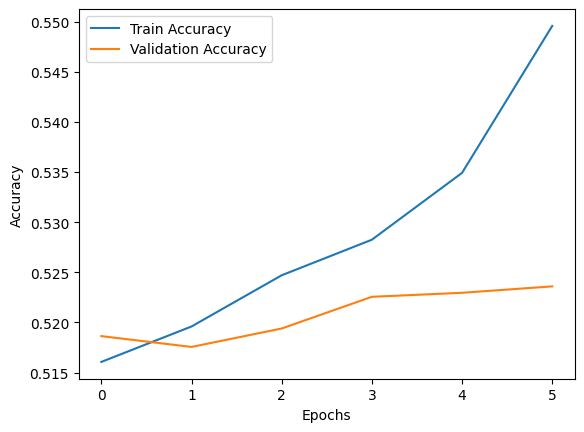

In [ ]:
# 8️⃣ **رسم دقة التدريب والتقييم**
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

# Define the path to save the model in Google Drive
model_save_path = "/content/drive/MyDrive/Adv_DS/Accepted/abusive_dataset_content/sentiment_model_acc_61.h5"

# Save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

NameError: name 'model' is not defined

## for default dataset

try modela


In [ ]:
# Load Model for Prediction
from tensorflow.keras.models import load_model

model_save_path = "/content/drive/MyDrive/Adv_DS/Accepted/abusive_dataset_content/sentiment_model_acc_61.h5"

# Load the saved model
#loaded_model = load_model(model_save_path)
print("Model loaded successfully.")

# Example Predictions
new_texts = ["المغزى من كلامي يا تدعمهم يا تكرمنا بسكوتك وما تتحلطم على غير سنع اللاعبين كلهم يلعبون سنين على هذا الرتم إلا هم توهم داخلين الجو مالهم حتى سنة ٢٠ قيم أقيام واجد كلوز وكذا لاعب من الاجانب اشاد فيهم وقال يحتاجون وقت ف باختصار لا تقعد تقول حرام فيهم cdl مالك شغل حرام ولا مب حرام","والله سلسلة خورافيه مع أطلق ثلاثي واضافه ابو السعد لفالكون شي عالمي❤","​​لاعب رقم اثنين سيئ ناكب فانكوفر","​​يلععععععن اممم الحماااااااس","​​ول ول والله قيم عظيم","بو نجد مهند شادها معطيني ميوت من الشات عشاني سالت عن سماعه اذا نظامه كذا ف ابد بنترك البث ونطلع اذا كان الادمن يعطي ميوت عشاني سالت عن سماعه وانا اساسا اسال الشباب ماسالته ...","​​ليبتون و فيليه ما يصير مع بعض ؟","​​يخربيتك مهند","قسم بالله ان هذي ذكية ", " والله ياخذ النصر سبايك ما يعرفون يلعبون "]
new_text_seq = tokenizer.texts_to_sequences(new_texts)
new_text_pad = pad_sequences(new_text_seq, maxlen=max_length)

# Make predictions using the loaded model
predictions = model.predict(new_text_pad)
predicted_labels = ["P" if pred < 0.5 else "N" for pred in predictions.flatten()]
confidences = [pred[0] if label == "P" else 1 - pred[0] for pred, label in zip(predictions, predicted_labels)]
# Print results
for i, (text, label, confidence) in enumerate(zip(new_texts, predicted_labels, confidences)):
    print(f"Text: {text}")
    print(f"Predicted Label: {label} (Confidence: {confidence:.4f})\n")

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Text: المغزى من كلامي يا تدعمهم يا تكرمنا بسكوتك وما تتحلطم على غير سنع اللاعبين كلهم يلعبون سنين على هذا الرتم إلا هم توهم داخلين الجو مالهم حتى سنة ٢٠ قيم أقيام واجد كلوز وكذا لاعب من الاجانب اشاد فيهم وقال يحتاجون وقت ف باختصار لا تقعد تقول حرام فيهم cdl مالك شغل حرام ولا مب حرام
Predicted Label: P (Confidence: 0.4954)

Text: والله سلسلة خورافيه مع أطلق ثلاثي واضافه ابو السعد لفالكون شي عالمي❤
Predicted Label: P (Confidence: 0.4994)

Text: ​​لاعب رقم اثنين سيئ ناكب فانكوفر
Predicted Label: N (Confidence: 0.4947)

Text: ​​يلععععععن اممم الحماااااااس
Predicted Label: N (Confidence: 0.4947)

Text: ​​ول ول والله قيم عظيم
Predicted Label: N (Confidence: 0.4947)

Text: بو نجد مهند شادها معطيني ميوت من الشات عشاني سالت عن سماعه اذا نظامه كذا ف ابد بنترك البث ونطلع اذا كان الادمن يعطي ميوت عشاني سالت عن سماعه وانا اساسا اسال الشباب ماسالته ...
Predicted Label: P (Confidence: 0.4961)

Text: ​​ليبتون و فيليه ما يصير مع بعض ؟
Pr

In [ ]:
# for
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Define the path to the saved model
model_load_path = "/content/drive/MyDrive/Adv_DS/Accepted/abusive_dataset_content/sentiment_model.h5"

# 3. Load the saved model
from tensorflow.keras.models import load_model
loaded_model = load_model(model_load_path)
print("Model loaded successfully.")

# 4. Prepare your new input data (text) for prediction
# Example new data
new_texts = ["قسم بالله ان هذي غبيه ", " والله ياخذ النصر سبايك ما يعرفون يلعبون "]

# Tokenize and pad the new texts the same way as during training
new_text_seq = tokenizer.texts_to_sequences(new_texts)
new_text_pad = pad_sequences(new_text_seq, maxlen=max_length)

# 5. Make predictions with the loaded model
predictions = model.predict(new_text_pad)

# 6. Interpret the results (convert predictions to sentiment labels)
sentiment_labels = ['negative', 'positive', 'neutral']  # Mapping to class labels

for i, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)  # Get the index of the highest probability
    sentiment = sentiment_labels[predicted_class]  # Get the corresponding sentiment label
    confidence = prediction[predicted_class]  # Get the confidence of the prediction
    print(f"Text: {new_texts[i]}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Text: قسم بالله ان هذي غبيه 
Predicted Sentiment: negative (Confidence: 0.9020)

Text:  والله ياخذ النصر سبايك ما يعرفون يلعبون 
Predicted Sentiment: negative (Confidence: 0.9665)

